## Water Quality Analysis and Potability Prediction

This notebook presents a machine learning approach to predict water potability based on various quality metrics. We explore the impact of feature selection on model performance using a Histogram-based Gradient Boosting Classification model.


### 1. Setup and Data Loading


In [58]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

np.random.seed(42)


In [59]:
graphs_dir = "../graphs"
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)
    print(f"Created directory: {graphs_dir}")
else:
    print(f"Directory already exists: {graphs_dir}")


Directory already exists: ../graphs


#### 1.1 Load and Examine the Dataset


In [60]:
df = pd.read_csv('../data/water_potability.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
display(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nBasic statistics:")
display(df.describe())


Dataset shape: (3276, 10)

First few rows of the dataset:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



Missing values in each column:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Basic statistics:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


#### 1.2 Data Visualization

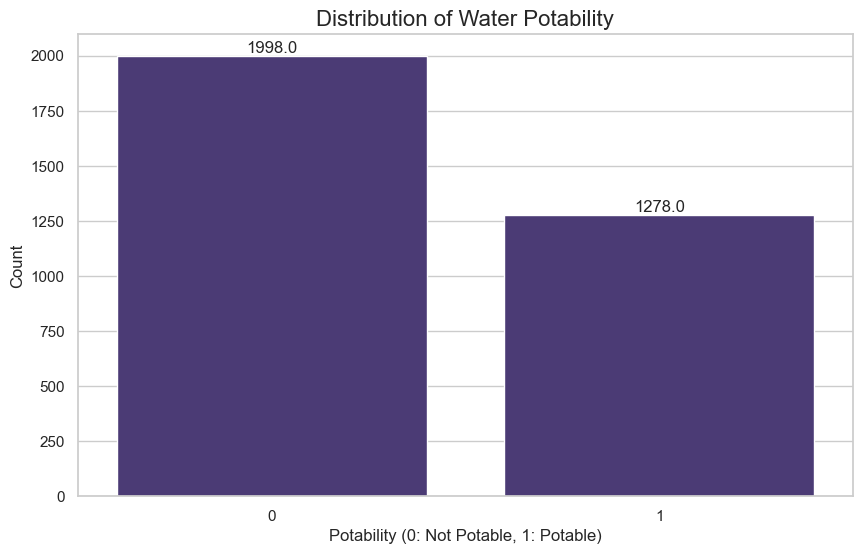

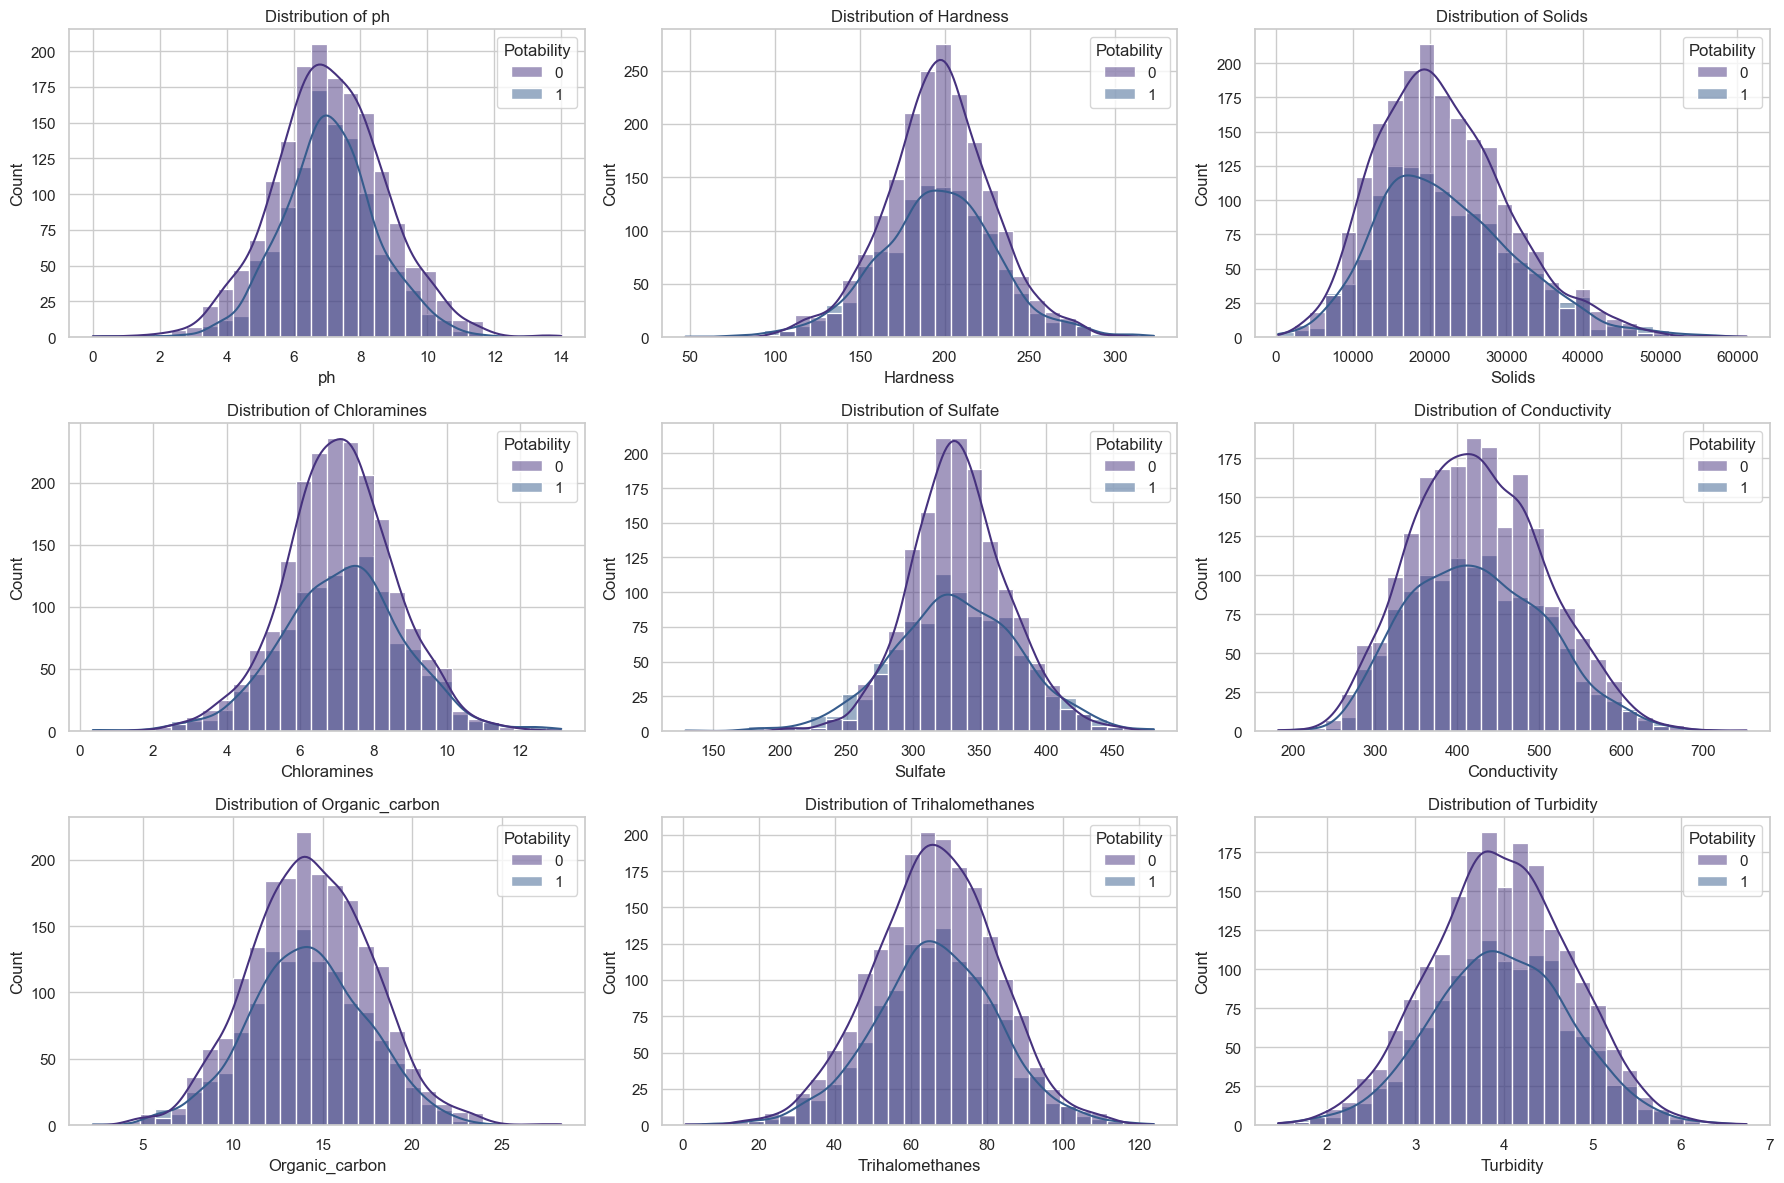

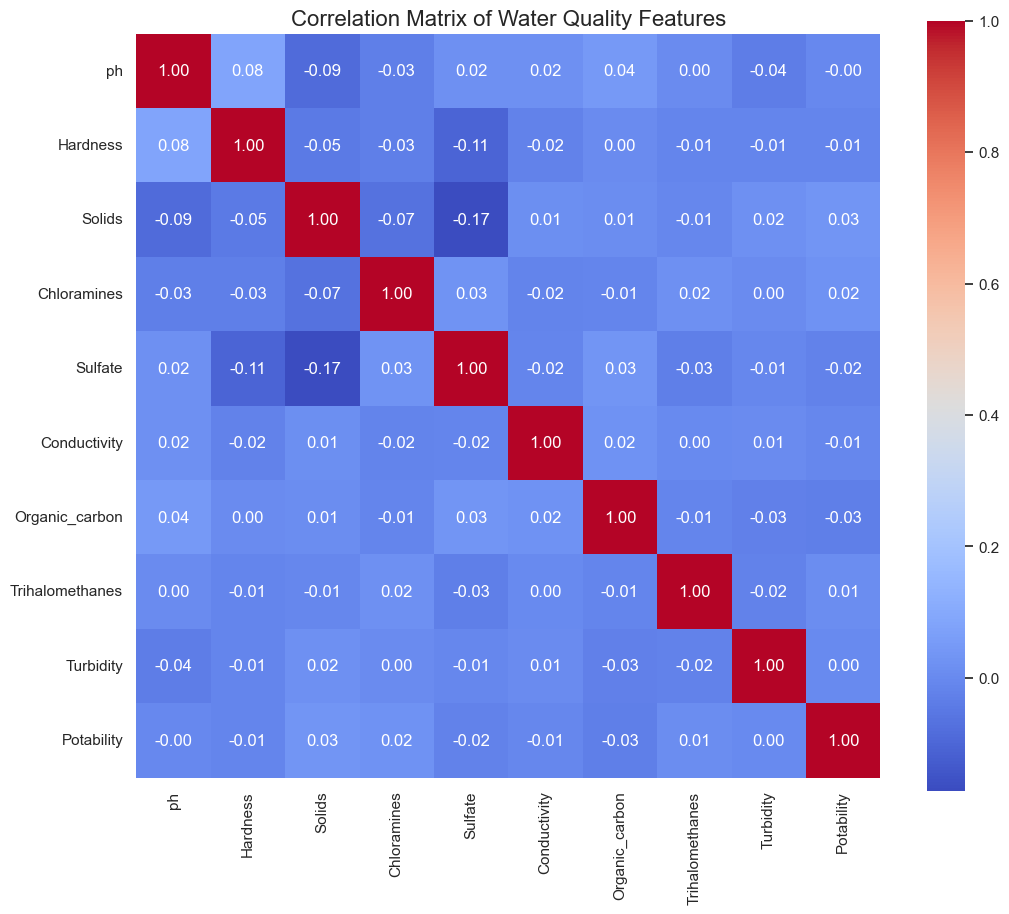

In [61]:
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Potability', data=df)
ax.set_title('Distribution of Water Potability', fontsize=16)
ax.set_xlabel('Potability (0: Not Potable, 1: Potable)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)
plt.savefig(os.path.join(graphs_dir, 'potability_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(18, 12))
for i, column in enumerate(df.drop('Potability', axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=column, hue='Potability', kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'feature_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Water Quality Features', fontsize=16)
plt.savefig(os.path.join(graphs_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2. Experiment Setup and Model Training

In [62]:
def get_model_and_params(model_name):
    if model_name == 'HistGradientBoosting':
        model = HistGradientBoostingClassifier(random_state=42)
        param_dist = {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [15, 31, 63, None],
            'min_samples_leaf': [20, 30, 50],
            'l2_regularization': [0.0, 0.1, 0.5]
        }
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(random_state=42)
        param_dist = {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model, param_dist

def run_experiment(df, drop_columns, model_name='HistGradientBoosting'):
    df2 = df.copy()
    title = f"{model_name} - "
    title += "Dropped 'Organic_carbon' & 'Trihalomethanes'" if drop_columns else "All columns included"

    if drop_columns:
        df2 = df2.drop(['Organic_carbon', 'Trihalomethanes'], axis=1)
    df2 = df2.dropna()

    X = df2.drop('Potability', axis=1)
    y = df2['Potability']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model, param_dist = get_model_and_params(model_name)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    if drop_columns and model_name == 'RandomForest':
        joblib.dump(best_model, './water_potability_predictor.pkl')
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n=== {title} ===")
    print("Best hyperparameters:", search.best_params_)
    print(f"Test accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'title': title,
        'model_name': model_name,
        'best_params': search.best_params_,
        'accuracy': acc,
        'report': report,
        'confusion_matrix': conf_matrix,
        'model': best_model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }


### 3. Experiment Execution

We'll run experiments with multiple classifiers:
1. HistGradientBoosting
2. XGBoost
3. RandomForest

Each classifier will be tested with:
- All columns included
- 'Organic_carbon' and 'Trihalomethanes' columns dropped


#### 3.1 Define Models and Initialize Results


In [63]:
models = ['HistGradientBoosting', 'XGBoost', 'RandomForest']
results = {}


#### 3.2 Run Experiments with All Columns


In [64]:
for model_name in models:
    key = f"{model_name}_all"
    results[key] = run_experiment(df, drop_columns=False, model_name=model_name)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== HistGradientBoosting - All columns included ===
Best hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_iter': 100, 'learning_rate': 0.01, 'l2_regularization': 0.0}
Test accuracy: 0.6725
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       240
           1       0.67      0.37      0.48       163

    accuracy                           0.67       403
   macro avg       0.67      0.62      0.62       403
weighted avg       0.67      0.67      0.65       403

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== XGBoost - All columns included ===
Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Test accuracy: 0.6700
Classification Report:
              precision    recall  f1-score   support

           0       0.65    

#### 3.3 Run Experiments with Dropped Columns


In [65]:
for model_name in models:
    key = f"{model_name}_dropped"
    results[key] = run_experiment(df, drop_columns=True, model_name=model_name)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== HistGradientBoosting - Dropped 'Organic_carbon' & 'Trihalomethanes' ===
Best hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Test accuracy: 0.7028
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       254
           1       0.70      0.46      0.55       170

    accuracy                           0.70       424
   macro avg       0.70      0.66      0.67       424
weighted avg       0.70      0.70      0.69       424

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== XGBoost - Dropped 'Organic_carbon' & 'Trihalomethanes' ===
Best hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Test accuracy: 0.6863
Classification Report:
              precision    recall  f

### 4. Results Analysis and Visualization


#### 4.1 Define Visualization Settings


In [66]:
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#34495e', '#d35400']
consistent_cmap = 'coolwarm'


#### 4.2 Model Performance Comparison


<Figure size 1200x800 with 0 Axes>

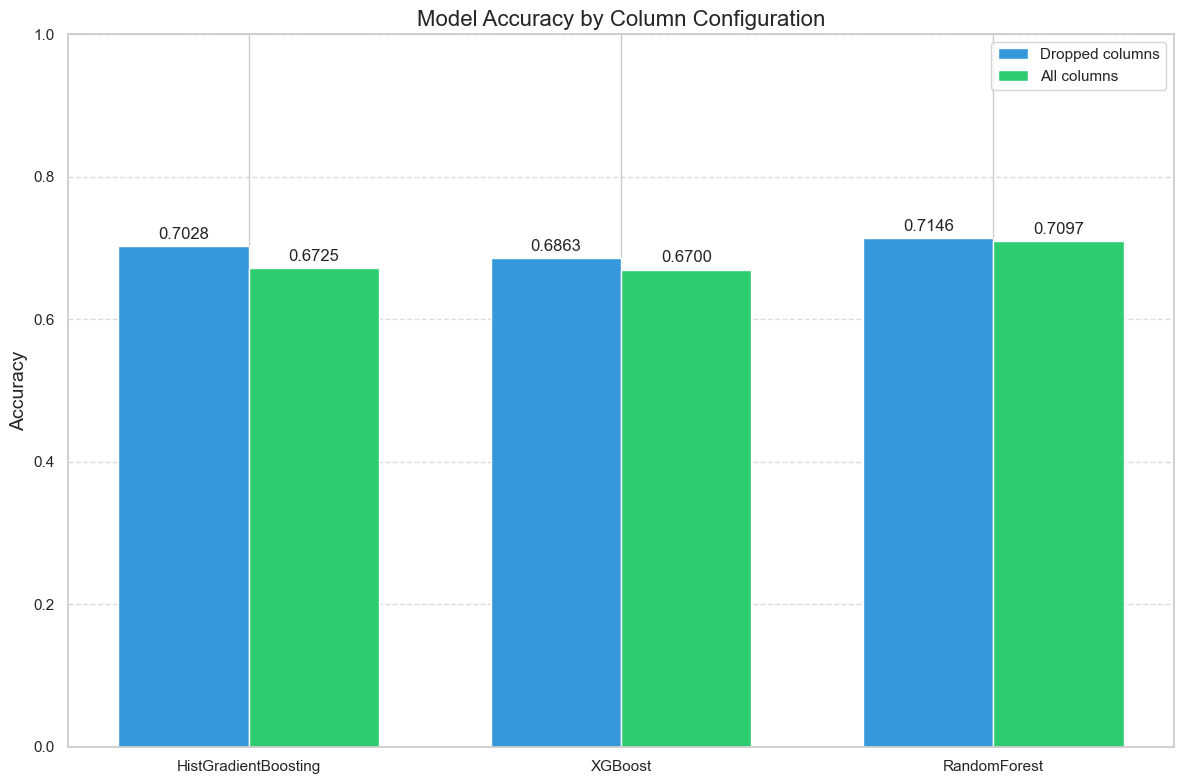

In [67]:
model_groups = {}
for key, result in results.items():
    model_name = result['model_name']
    if model_name not in model_groups:
        model_groups[model_name] = []
    model_groups[model_name].append(result)

all_accuracies = []
all_labels = []
all_colors = []

for i, (model_name, model_results) in enumerate(model_groups.items()):
    for result in model_results:
        all_accuracies.append(result['accuracy'])
        all_labels.append(result['title'])
        all_colors.append(colors[i % len(colors)])

sorted_indices = np.argsort(all_accuracies)[::-1]
all_accuracies = [all_accuracies[i] for i in sorted_indices]
all_labels = [all_labels[i] for i in sorted_indices]
all_colors = [all_colors[i] for i in sorted_indices]

plt.figure(figsize=(12, 8))
model_names = list(model_groups.keys())
dropped_accuracies = []
all_accuracies = []

for model_name in model_names:
    for result in model_groups[model_name]:
        if "Dropped" in result['title']:
            dropped_accuracies.append(result['accuracy'])
        else:
            all_accuracies.append(result['accuracy'])

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, dropped_accuracies, width, label='Dropped columns', color=colors[0])
rects2 = ax.bar(x + width/2, all_accuracies, width, label='All columns', color=colors[1])

ax.set_title('Model Accuracy by Column Configuration', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'model_accuracy_by_columns.png'), dpi=300, bbox_inches='tight')
plt.show()


#### 4.3 Confusion Matrices for Best Models


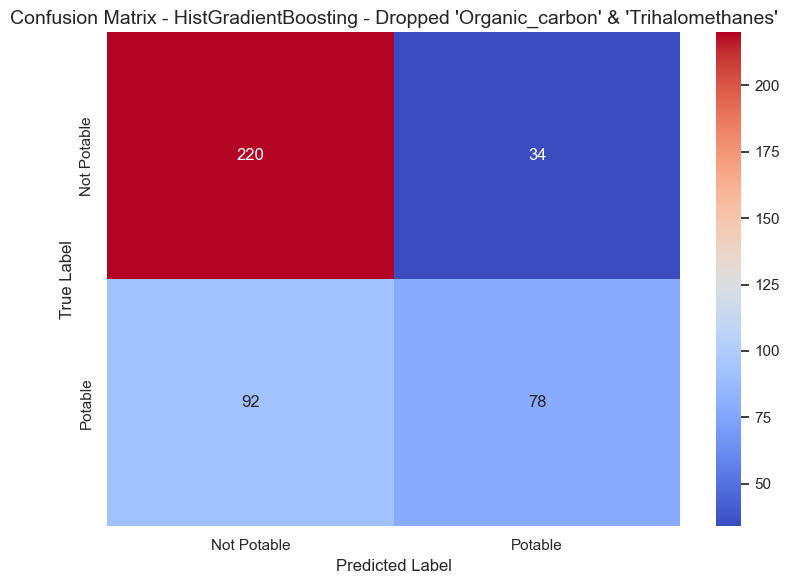

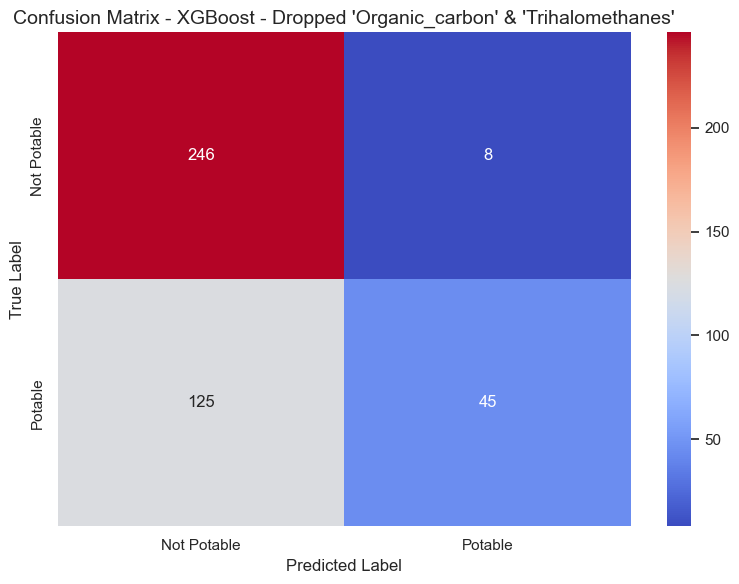

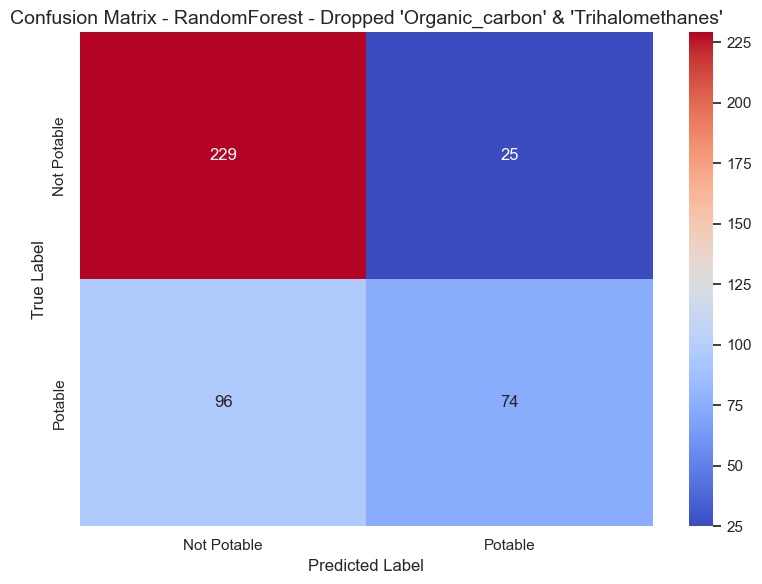

In [68]:
best_models = {}
for model_name, model_results in model_groups.items():
    best_model = max(model_results, key=lambda x: x['accuracy'])
    best_models[model_name] = best_model

for model_name, result in best_models.items():
    plt.figure(figsize=(8, 6))
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap=consistent_cmap)
    plt.title(f'Confusion Matrix - {result["title"]}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks([0.5, 1.5], ['Not Potable', 'Potable'])
    plt.yticks([0.5, 1.5], ['Not Potable', 'Potable'])

    filename = f'confusion_matrix_{model_name}.png'
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()


#### 4.4 F1 Score Comparison for Best Models


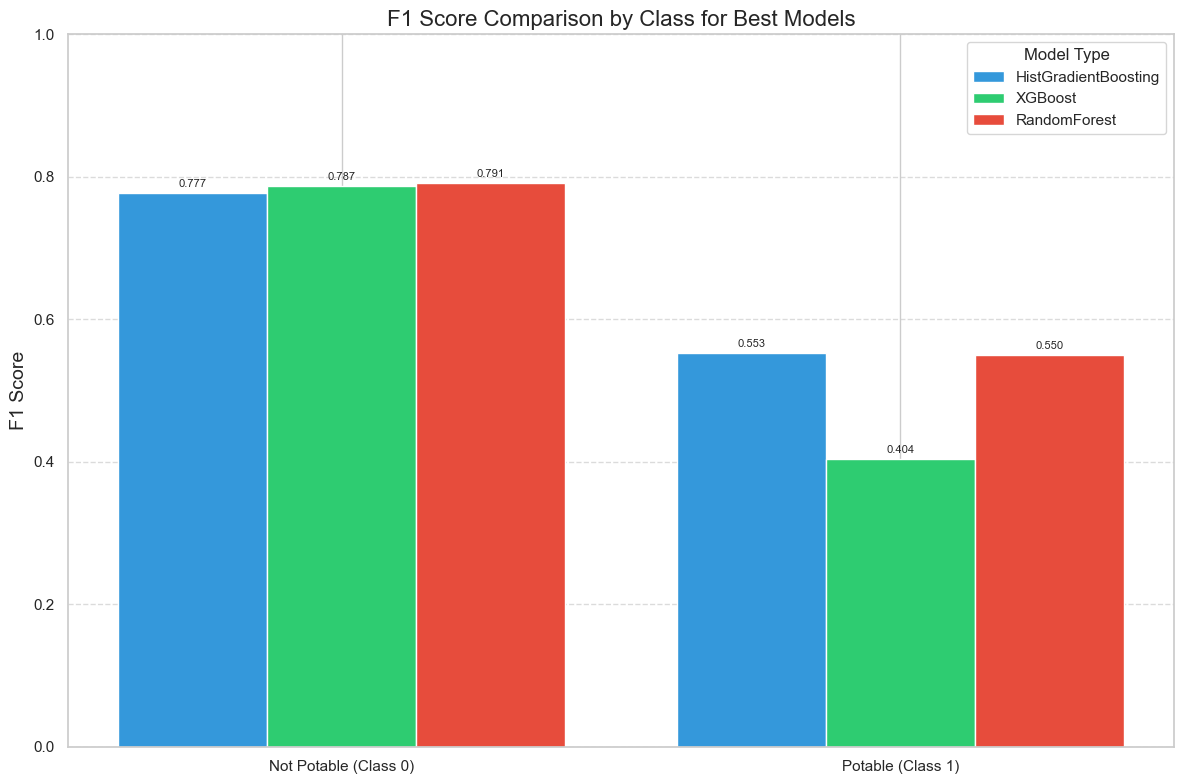

In [69]:
# Compare F1 scores for the best models
f1_scores = {}
for model_name, result in best_models.items():
    f1_scores[model_name] = [
        result['report']['0']['f1-score'],
        result['report']['1']['f1-score']
    ]

x = np.arange(2)
width = 0.8 / len(f1_scores)

fig, ax = plt.subplots(figsize=(12, 8))
for i, (model_name, scores) in enumerate(f1_scores.items()):
    offset = (i - len(f1_scores) / 2 + 0.5) * width
    rects = ax.bar(x + offset, scores, width, label=model_name, color=colors[i % len(colors)])

    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_title('F1 Score Comparison by Class for Best Models', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(['Not Potable (Class 0)', 'Potable (Class 1)'])
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_ylim(0, 1)
ax.legend(title="Model Type")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'best_model_f1_scores.png'), dpi=300, bbox_inches='tight')
plt.show()
